In [5]:
import sys
import os
sys.path.append(os.path.abspath(".."))  

In [22]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import logging
import matplotlib.pyplot as plt

from src.config import load_config
from src.logging_config import setup_logging
from src.utils import ensure_dir, check_raster
from src.raster_ops import merge_tiles, read_raster_match
from src.netcdf_ops import extract_monthly_mean, extract_ssrd_may_process
from src.estk_ops import clip_and_reproject_estk
from src.npp import compute_npp

setup_logging() 


<Axes: >

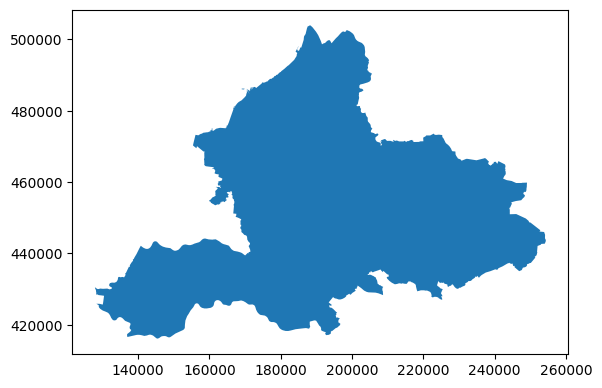

In [18]:
cfg = load_config("../src/config.yaml")
output_dir = Path(cfg["paths"]["output_dir"])
ensure_dir(output_dir)

provinces = gpd.read_file(cfg["paths"]["province_shapefile"])
gelderland = provinces[provinces["PV_NAAM"].str.contains("Gelderland", case=False)]

gelderland.plot()


In [10]:
lai_tiles = [Path(cfg["paths"]["LAI_UGT_path"]), Path(cfg["paths"]["LAI_UFT_path"])]
lai_merged_path = Path(cfg["outputs"]["lai_merged"])

merged_lai = merge_tiles(
    tile_paths=lai_tiles,
    boundary=gelderland.to_crs(cfg["crs"]["target"]),
    target_crs=cfg["crs"]["target"],
    scale_factor=cfg["scaling"]["LAI"],
    out_path=lai_merged_path,
)
check_raster(lai_merged_path, expected_crs=cfg["crs"]["target"])

2025-08-09 20:02:26 [INFO] src.raster_ops: Loading raster ../data/NPP_inputs/CLMS_products/VI_20220510T104621_S2A_T31UGT-010m_V101_LAI_FIXED_Qgis.tif
2025-08-09 20:02:29 [INFO] src.raster_ops: Reprojecting clipped raster to EPSG:32631
2025-08-09 20:02:30 [INFO] src.raster_ops: Loading raster ../data/NPP_inputs/CLMS_products/VI_20220510T104621_S2A_T31UFT-010m_V101_LAI_FIXED_Qgis.tif
2025-08-09 20:02:33 [INFO] src.raster_ops: Reprojecting clipped raster to EPSG:32631
2025-08-09 20:02:35 [INFO] src.raster_ops: Saving merged raster to ../data/NPP_processed_inputs/output_LAI_UTM31N.tif
2025-08-09 20:02:36 [INFO] src.utils: output_LAI_UTM31N.tif — Size: 333.6 MB | CRS: EPSG:32631 | Bounds: BoundingBox(left=637310.0, bottom=5800020.0, right=763240.0, top=5733800.0)


In [11]:
fapar_tiles = [Path(cfg["paths"]["FAPAR_UGT_path"]), Path(cfg["paths"]["FAPAR_UFT_path"])]
fapar_merged_path = Path(cfg["outputs"]["fapar_merged"])

merged_fapar = merge_tiles(
    tile_paths=fapar_tiles,
    boundary=gelderland.to_crs(cfg["crs"]["target"]),
    target_crs=cfg["crs"]["target"],
    scale_factor=cfg["scaling"]["FAPAR"],
    out_path=fapar_merged_path,
)
check_raster(fapar_merged_path, expected_crs=cfg["crs"]["target"])

2025-08-09 20:02:49 [INFO] src.raster_ops: Loading raster ../data/NPP_inputs/CLMS_products/VI_20220510T104621_S2A_T31UGT-010m_V101_FAPAR_FIXED_Qgis.tif
2025-08-09 20:02:51 [INFO] src.raster_ops: Reprojecting clipped raster to EPSG:32631
2025-08-09 20:02:52 [INFO] src.raster_ops: Loading raster ../data/NPP_inputs/CLMS_products/VI_20220510T104621_S2A_T31UFT-010m_V101_FAPAR_FIXED_Qgis.tif
2025-08-09 20:02:55 [INFO] src.raster_ops: Reprojecting clipped raster to EPSG:32631
2025-08-09 20:02:57 [INFO] src.raster_ops: Saving merged raster to ../data/NPP_processed_inputs/output_FAPAR_UTM31N.tif
2025-08-09 20:02:58 [INFO] src.utils: output_FAPAR_UTM31N.tif — Size: 333.6 MB | CRS: EPSG:32631 | Bounds: BoundingBox(left=637310.0, bottom=5800020.0, right=763240.0, top=5733800.0)


In [ ]:
gelderland_wgs84 = gelderland.to_crs("EPSG:4326")
bbox = gelderland_wgs84.total_bounds  
bbox_coords = {
    "lon_min": float(bbox[0]),
    "lon_max": float(bbox[2]),
    "lat_min": float(bbox[1]),
    "lat_max": float(bbox[3]),
}

In [13]:
temp_nc_path = Path(cfg["paths"]["temp_nc_path"])
temp_out_path = Path(cfg["outputs"]["temperature"])

extract_monthly_mean(
    nc_path=temp_nc_path,
    varname="TEMP",
    bbox_coords=bbox_coords,
    time_slice=cfg["npp"]["month_slice"],
    out_crs=cfg["crs"]["target"],
    out_path=temp_out_path,
)
check_raster(temp_out_path, expected_crs=cfg["crs"]["target"])


2025-08-09 20:03:28 [INFO] src.netcdf_ops: Selecting time slice 2022-05-01 to 2022-05-31 from ../data/NPP_inputs/Temps/single_level_2m_daily_mean_temp_2022_NL_ERA5.nc
2025-08-09 20:03:28 [INFO] src.netcdf_ops: Wrote raster to ../data/NPP_processed_inputs/temperature_Gelderland.tif
2025-08-09 20:03:28 [INFO] src.utils: temperature_Gelderland.tif — Size: 0.0 MB | CRS: EPSG:32631 | Bounds: BoundingBox(left=626913.5250109878, bottom=5719222.62178713, right=765030.0100936119, top=5837608.180429379)


In [14]:
ssrd_nc_path = Path(cfg["paths"]["ssrd_nc_path"])
ssrd_out_path = Path(cfg["outputs"]["ssrd"])

extract_ssrd_may_process(
    nc_path=ssrd_nc_path,
    varname="ssrd",
    bbox_coords=bbox_coords,
    time_slice=cfg["npp"]["month_slice"],
    out_crs=cfg["crs"]["target"],
    out_path=ssrd_out_path,
)
check_raster(ssrd_out_path, expected_crs=cfg["crs"]["target"])


2025-08-09 20:03:40 [INFO] src.netcdf_ops: Processed and saved SSRD to ../data/NPP_processed_inputs/ssrd_Gelderland.tif
2025-08-09 20:03:40 [INFO] src.utils: ssrd_Gelderland.tif — Size: 0.0 MB | CRS: EPSG:32631 | Bounds: BoundingBox(left=640609.5431240719, bottom=5736087.826350521, right=755546.7451127283, top=5831868.828007735)


In [15]:
estk_full_path = Path(cfg["paths"]["estk_full_path"])
estk_clipped_path = Path(cfg["estk"]["clipped_path"])
estk_reprojected_path = Path(cfg["estk"]["reprojected_path"])

clip_and_reproject_estk(
    estk_raster_path=estk_full_path,
    boundary_gdf=gelderland,
    clipped_raster_path=estk_clipped_path,
    reprojected_raster_path=estk_reprojected_path,
    target_crs=cfg["crs"]["target"],
)
check_raster(estk_reprojected_path, expected_crs=cfg["crs"]["target"])


2025-08-09 20:03:48 [INFO] src.estk_ops: Opening ESTK raster: ../data/NPP_inputs/ESTK_kaarten/NL_2022_10m.tif
2025-08-09 20:03:48 [INFO] src.estk_ops: Masking ESTK raster with boundary polygon
2025-08-09 20:03:50 [INFO] src.estk_ops: Saving clipped ESTK raster to ../data/NPP_processed_inputs/ESTK_Gelderland.tif
2025-08-09 20:03:50 [INFO] src.estk_ops: Reprojecting clipped raster to EPSG:32631
2025-08-09 20:03:52 [INFO] src.estk_ops: Saving reprojected ESTK raster to ../data/NPP_processed_inputs/ESTK_Gelderland_32631.tif
2025-08-09 20:03:53 [INFO] src.estk_ops: Completed ESTK clipping and reprojection
2025-08-09 20:03:53 [INFO] src.utils: ESTK_Gelderland_32631.tif — Size: 118.9 MB | CRS: EPSG:32631 | Bounds: BoundingBox(left=634880.1402805636, bottom=5733224.9038243145, right=764152.7573115675, top=5825180.992101532)


In [19]:
conversion_table = pd.read_excel(cfg["paths"]["conversion_table_path"], engine="openpyxl")
conversion_table.columns = conversion_table.columns.str.strip()
conversion_table = conversion_table.set_index("Pixelwaarde")
conversion_table.head()


,ESTK omschrijving,MODIS LC class,eps_max,SLA,Leaf_resp_base,Root_resp_base,Root_Leaf_ratio,Wood_resp_base,Wood_Leaf_ratio,T_max,T_min
Pixelwaarde,,,,,,,,,,,
1,Productiebos,6,0.000962,14.1,0.00604,0.00519,1.2,0.00397,0.182,8.31,-8
2,Akkerbouw_reg,1,0.001044,30.4,0.00980,0.00819,2.0,0.00000,0.000,12.02,-8
3,Ov_nat_grasland,2,0.000860,37.5,0.00980,0.00819,2.6,0.00000,0.000,12.02,-8
4,Groenvoorziening,7,0.001051,21.5,0.00778,0.00519,1.1,0.00371,0.203,9.50,-7
7,Infra_groen,4,0.001281,9.0,0.00869,0.00519,1.0,0.00436,0.079,8.61,-8


In [20]:
npp_output_path = Path(cfg["outputs"]["npp"])

npp_raster = compute_npp(
    lai_path=lai_merged_path,
    fapar_path=fapar_merged_path,
    temp_path=temp_out_path,
    ssrd_path=ssrd_out_path,
    estk_path=estk_reprojected_path,
    conversion_df=conversion_table,
    output_path=npp_output_path,
)

check_raster(npp_output_path, expected_crs=cfg["crs"]["target"])


2025-08-09 20:04:50 [INFO] src.npp: Loading rasters for NPP computation
2025-08-09 20:04:50 [INFO] src.npp: Converting temperature from Kelvin to Celsius
2025-08-09 20:04:50 [INFO] src.npp: Aligning rasters to LAI grid
2025-08-09 20:04:58 [INFO] src.npp: Processing 29 valid ESTK classes for NPP
2025-08-09 20:06:31 [INFO] src.npp: NPP raster saved to ../NPP_outputs/NPP_Gelderland_May2022.tif
2025-08-09 20:06:31 [INFO] src.utils: NPP_Gelderland_May2022.tif — Size: 667.2 MB | CRS: EPSG:32631 | Bounds: BoundingBox(left=637310.0, bottom=5800020.0, right=763240.0, top=5733800.0)


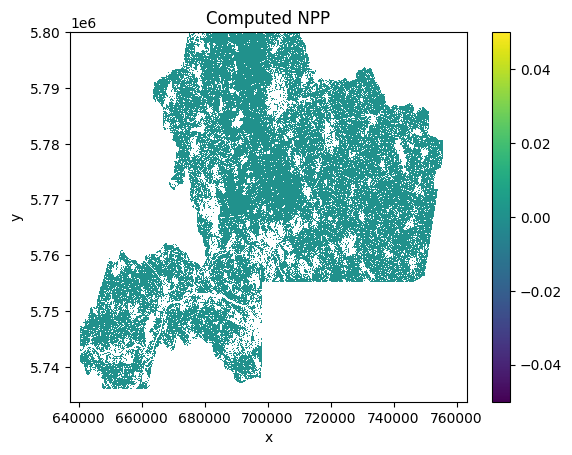

In [ ]:
npp_raster.plot(cmap="viridis")
plt.title("Computed NPP")
plt.show()
